# **Inteligência Artificial - 2019.2**
> Grupo: Daniel Mitre, Héricles Emanuel, José Renan

### Gartic AI - Classificador de Sketches

#### **Sobre o Projeto**

- Dataset  
    **. Google Quickdraw Dataset:** *Uma coleção com 50 milhões de desenhos divididos em 345 categorias.*  
    **. Conteúdo dos dados:** 
        key_id      | Um identificador exclusivo em todos os desenhos.
        word        | Categoria do desenho.
        recognized  | Se a palavra foi reconhecida pelo jogo.
        timestamp   | Quando o desenho foi criado.
        countrycode | Código do país do jogador
        drawing     | Matriz que representa o desenho vetorial
    **. Formatos disponíveis:**  Newline Delimited JSON (`.ndjson`), Arquivos binários (`.bin`), Bitmaps numpy (`.npy`)  
    **. Disponível em:** https://console.cloud.google.com/storage/quickdraw_dataset/


- Modelo  
    **. Rede Neural Convolucional** (CNN)  
      3 Camadas de Pooling, 3 Camadas de Convolução, 1 Flatten, 2 Dense  
    **. Optimizer:** Adam  
    **. Função de Custo:** Categorical Cross-entropy  
    **. Métricas:** Acurácia


### Importação de Módulos e Bibliotecas

In [0]:
import os
import glob
import numpy as np
from tensorflow.keras import layers
from tensorflow import keras 
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import urllib.request
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import matplotlib
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


### Seleção de classes
O Dataset possui 345 categorias. Por motivos de otimização, foram selecionadas 10 delas para o experimento.  
O Número máximo de exemplos por categoria é de 20000 (por padrão).  
Os dados foram divididos em conjuntos de **treino** e **teste**.  
  - O conjunto de treino, corresponde a cerca de 80% dos dados usados no experimento. (~16k exemplos/item).  
  - O conjunto de teste, corresponde a cerca de 20% dos dados usados no experimento. (~4k exemplos/item)

Dentre os formatos disponíveis para download do dataset, o formato utilizado no experimento foi `.npy` (Numpy Bitmap).

> O tamanho da imagem também foi reduzido para fins de otimização.

In [0]:
class_names = ["bee", "book", "cactus", "swan", "submarine", "clock", "tiger", "toaster", "underwear", "umbrella"]

DATABASE_URL = "https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/"

### Download e preparação dos dados
Os dados são baixados do bucket do google, onde estão os datasets com os formatos disponíveis.

A função `download_and_load` baixa e prepara os dados para o experimento. Ela também faz o reshape e a randomização dos dados e particionamos eles nos conjuntos de treino e teste.

In [0]:
def download_and_load(test_split = 0.2, max_items_per_class = 20000):
  root = "data"
  print("Downloading ...")
  for img_class in class_names:
    path = DATABASE_URL + img_class +".npy"
    urllib.request.urlretrieve(path, "{}/{}.npy".format(root, img_class))
  print("Loading ...")
  
  x = np.empty([0, 784])
  y = np.empty([0])

  for idx, file in enumerate(class_names):
      data = np.load("{}/{}.npy".format(root, file))
      data = data[0: max_items_per_class, :]
      labels = np.full(data.shape[0], idx)

      x = np.concatenate((x, data), axis=0)
      y = np.append(y, labels)

  data = None
  labels = None

  # Randomização
  permutation = np.random.permutation(y.shape[0])
  x = x[permutation, :]
  y = y[permutation]

  # Reshape 
  x = 255 - np.reshape(x, (x.shape[0], 28, 28))

  # Data split 
  test_size  = int(x.shape[0]/100*(test_split*100))

  x_test = x[0:test_size, :]
  y_test = y[0:test_size]

  x_train = x[test_size:x.shape[0], :]
  y_train = y[test_size:y.shape[0]]
  
  print("Training Data : ", x_train.shape[0])
  print("Testing  Data : ", x_test.shape[0])
  return x_train, y_train, x_test, y_test, class_names

Executamos a função para obter os conjuntos de treino e teste. Seus dados e rótulos.

In [0]:
x_train, y_train, x_test, y_test, class_names = download_and_load()

Loading ...
Training Data :  160000
Testing  Data :  40000


### Explorando os dados
Aqui, podemos verificar quais as classes que selecionamos anteriormente para o experimento.

In [0]:
class_names

['bee',
 'book',
 'cactus',
 'swan',
 'submarine',
 'clock',
 'tiger',
 'toaster',
 'underwear',
 'umbrella']

Temos a função de visualização de classes. Podemos olhar o nosso conjunto de dados e pegamos 10 exemplos de cada classe escolhida, para termos uma ideia de como são nossos sketches.

In [0]:
def visualize_classes():
  for i in range(0, 10):
    img_batch = x_train[y_train == i][0:10]
    img_batch = np.reshape(img_batch, (img_batch.shape[0]*img_batch.shape[1], img_batch.shape[2]))
    if i > 0:
      img = np.concatenate([img, img_batch], axis = 1)
    else:
      img = img_batch
  plt.figure(figsize=(10,20))
  plt.axis('off')
  plt.imshow(img)

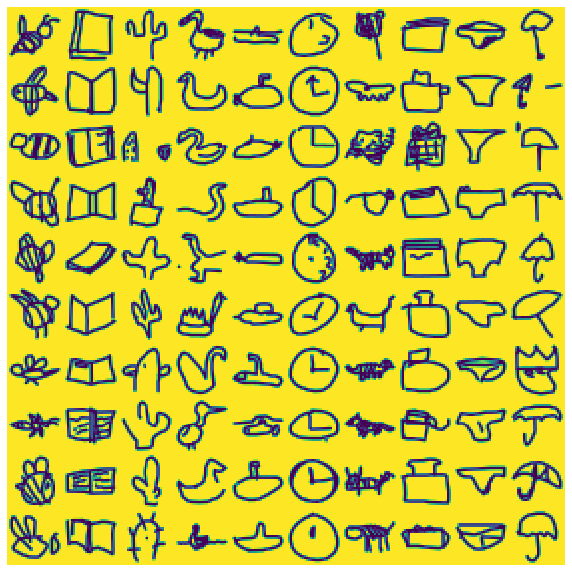

In [0]:
visualize_classes()

#### Distribuição de rótulos

Conseguimos ver uma representação gráfica da distribuição dos rótulos nos nossos conjuntos de treino e teste. Fica claro que o número de exemplos chega a ser quase o mesmo para cada classe, e também podemos confirmar o particionamento conforme fizemos acima. 80% do conjunto para treino e 20% para teste.

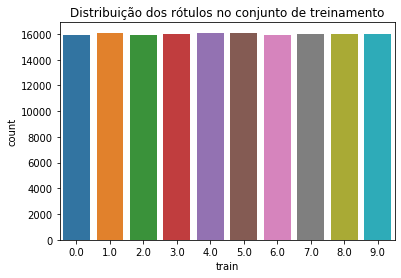

In [0]:
data = {}
data['train'] = y_train
df = pd.DataFrame.from_dict(data)
ax = sns.countplot(x = 'train', data=df).set_title("Distribuição dos rótulos no conjunto de treinamento")

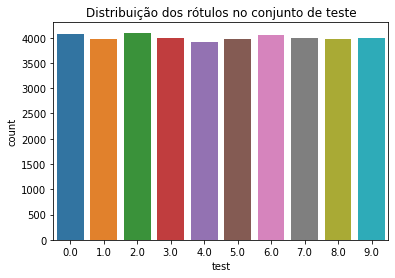

In [0]:
data = {}
data['test'] = y_test
df = pd.DataFrame.from_dict(data)
ax = sns.countplot(x = 'test', data=df).set_title("Distribuição dos rótulos no conjunto de teste")

#### t-SNE

Para explorar um pouco mais os dados, conseguimos usar t-SNE para termos uma visualização dos nossos dados que nos ajuda a perceber a relação de similaridade entre as classes escolhidas. 

> **O que é t-SNE?**  
*O t-SNE: t-Distributed Stochastic Neighbor Embedding é uma técnica de redução de dimensionalidade que é particularmente bem adaptada para visualizar bancos de dados com muitas dimensões.O objetivo do t-SNE é a partir de um conjunto de pontos em um espaço multi-dimensional encontrar uma representação fiel desses pontos em um espaço de dimensão menor, geralmente um plano 2D.*

In [0]:
def scatter(x, colors):
    palette = np.array(sns.color_palette("hls", 10))

    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    txts = []
    for i in range(10):
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, class_names[i], fontsize=15)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)
        
def plot_tsne(X, y):
  print('Calculando t-SNE...')
  proj = TSNE().fit_transform(X)
  scatter(proj, y)

Com a visualização abaixo, conseguimos enxergar nossos dados distribuídos num plano 2D. Isso nos ajuda a ver, por exemplo, que os desenhos de tigres podem ser fácilmente confundidos com desenhos de abelha, mas difícilmente confundidos com relógios.

Calculando t-SNE...


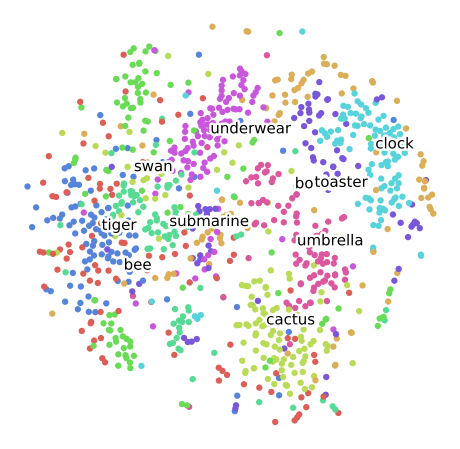

In [0]:
X = np.reshape(x_train, (x_train.shape[0], 28 * 28))[0:1000]
y = y_train[0:1000]
plot_tsne(X, y)

### Modelo

Agora, começamos a montar o nosso modelo.
Inicialmente, fazemos o reshape e a normalização dos dados. Em seguida, usando a função `to_categorical`, convertemos os vetores de classes para matrizes. Pelo fato de nosso problema ser em torno de decisões sobre classes, ou seja, categórico, precisamos também fazer com que nosso modelo consiga apontar qual é categoria mais provável de rotular corretamente uma imagem. 

In [0]:
image_size = 28

# Reshape and normalize
x_train = x_train.reshape(x_train.shape[0], image_size, image_size, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], image_size, image_size, 1).astype('float32')

x_train /= 255.0
x_test /= 255.0

# Convert class vectors to class matrices
y_train = keras.utils.to_categorical(y_train, len(class_names))
y_test = keras.utils.to_categorical(y_test, len(class_names))

Começamos a construir um modelo de forma sequencial. Contamos com 3 Camadas de convolução e 3 camadas de Pooling. Além disso, temos uma camada Flatten para reduzir a dimensão de vetores e por fim duas camadas Dense. 

In [0]:
# Sequential Model
model = keras.Sequential()

# Layers
model.add(layers.Convolution2D(16, (3, 3),
                        padding='same',
                        input_shape=x_train.shape[1:], activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(32, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(64, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size =(2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='tanh'))
model.add(layers.Dense(len(class_names), activation='softmax'))

# Optimizer
adam = tf.train.AdamOptimizer()
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)              

Nos preparamos também para criar checkpoints do nosso modelo a cada epoch. A função de criação de checkpoint (que salva nosso modelo) é invocada como callback no fim de cada epoch.

In [0]:
filepath = filepath="models/drawing-classifier-{epoch:02d}.hdf5"
checkpoint = ModelCheckpoint(filepath, verbose=1)

In [0]:
history = model.fit(x = x_train, y = y_train, validation_split=0.1, batch_size = 256, epochs=20, callbacks=[checkpoint])

Train on 144000 samples, validate on 16000 samples
Epoch 1/20
143872/144000 [============================>.] - ETA: 0s - loss: 0.5805 - acc: 0.8250
Epoch 00001: saving model to models/drawing-classifier-01.hdf5
144000/144000 [==============================] - 97s 672us/sample - loss: 0.5802 - acc: 0.8250 - val_loss: 0.3534 - val_acc: 0.8945
Epoch 2/20
143872/144000 [============================>.] - ETA: 0s - loss: 0.3140 - acc: 0.9075
Epoch 00002: saving model to models/drawing-classifier-02.hdf5
144000/144000 [==============================] - 96s 668us/sample - loss: 0.3140 - acc: 0.9075 - val_loss: 0.2906 - val_acc: 0.9133
Epoch 3/20
143872/144000 [============================>.] - ETA: 0s - loss: 0.2633 - acc: 0.9215
Epoch 00003: saving model to models/drawing-classifier-03.hdf5
144000/144000 [==============================] - 97s 674us/sample - loss: 0.2633 - acc: 0.9215 - val_loss: 0.2558 - val_acc: 0.9227
Epoch 4/20
143872/144000 [============================>.] - ETA: 0s - los

Agora podemos ver o score do nosso modelo a partir da acurácia. Fazendo a avaliação usando os dados de teste.

In [0]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test accuarcy: {:0.2f}%'.format(score[1] * 100))

Podemos capturar as predições corretas do nosso modelo, e ver que ele já consegue classificar as imagens corretamente,

True Label  book
Pred Label  book


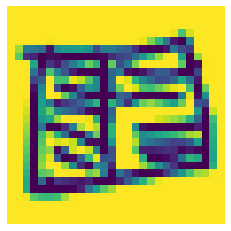

In [0]:
yhat = np.argmax(model.predict(x_test), axis = 1)
y    = np.argmax(y_test, axis = 1)

labels = np.argwhere((y == yhat) == True).squeeze()

idx = np.random.choice(labels)

print('True Label ',class_names[y[idx]])
print('Pred Label ',class_names[yhat[idx]])
plt.imshow(x_test[idx].squeeze())
plt.axis('off')
plt.show()

Por não ser perfeito, também pode acontecer de uma imagem ser rotulada incorretamente. Não é muito frequente, dado que nosso modelo possui uma boa acurácia. É comum de acontecer em casos onde as imagens tem muito em comum, como tigre e abelha, como vimos na visualização do t-SNE.

True Label  bee
Pred Label  tiger


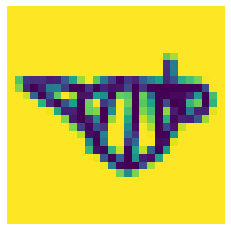

In [0]:
yhat = np.argmax(model.predict(x_test), axis = 1)
y    = np.argmax(y_test, axis = 1)

labels = np.argwhere((y == yhat) == False).squeeze()

idx = np.random.choice(labels)

print('True Label ',class_names[y[idx]])
print('Pred Label ',class_names[yhat[idx]])
plt.imshow(x_test[idx].squeeze())
plt.axis('off')
plt.show()

Para visualização da precisão do nosso modelo, conseguimos ver como ele se comporta ao longo das epochs para ambos os conjuntos de dados, e assim como sua precisão cresce, conseguimos acompanhar mais em baixo a função de custo, e vemos que vai diminuindo ao longo do treinamento.

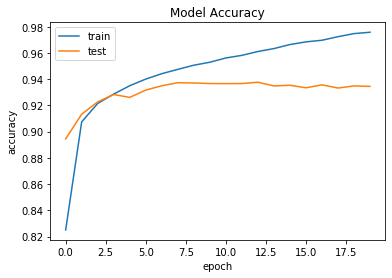

In [0]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

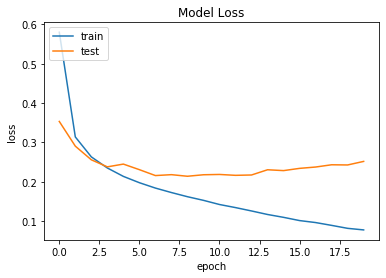

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Com a visualização do score por categoria, vemos que, embora no geral todas apresentaram uma boa pontuação, classes muito parecidas, como abelha e tigre tendem a ter um score menor que as outras.

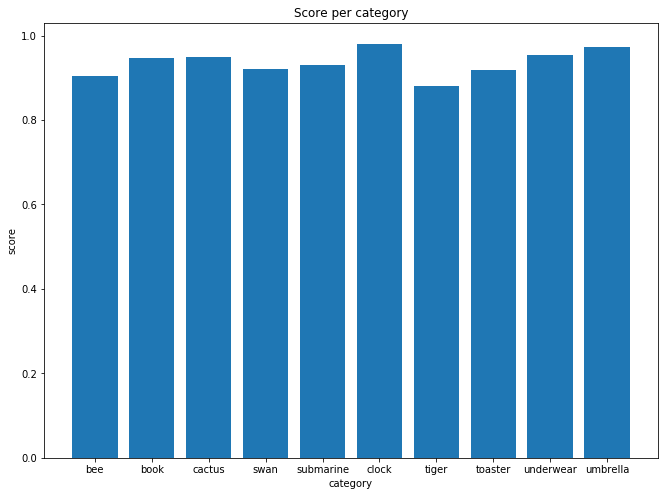

In [0]:
from sklearn.metrics import precision_recall_fscore_support
precisions, recall, f1_score, _ = precision_recall_fscore_support(y, yhat)

plt.figure(figsize=(11,8))
plt.bar(class_names, f1_score)
plt.title('Score per category')
plt.ylabel('score')
plt.xlabel('category')
plt.show()